## Introduction

Now we are goint to study the effect of center deviation, or in English miscentering offset. It occurs when the center of the dark matter halo does not perfectly coincide with the assumed center around which the tangential shear profiles are being measured. To do the analysis we will build some functions from scratch and then compare them with the same functions present in the library [cluster-lensing](http://jesford.github.io/cluster-lensing/).

In [2]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['legend.fontsize'] = 12
%matplotlib inline
from scipy.integrate import simps


from clusterlensing import ClusterEnsemble
import clusterlensing

import astropy.cosmology
from astropy import units as u

In [5]:
# Astropy Cosmology
cosmologia=astropy.cosmology.Planck13
cosmologia.Ob0

0.048252

The `cluster-lensin` library uses `astropy.cosmology.Planck13` from [Astropy](http://docs.astropy.org/) as the default cosmology, so to have greater precision in the comparisons we will define the same cosmology.

In [3]:
# I used this parameter in both cases.
rbins = np.logspace(np.log10(0.1) ,np.log10(10.0), num =200)

numRoff = 200
numTh = 200
numRbins = rbins.shape[0]
maxsig = 0.3

# I used this parameter just in the calculus of the offcenter.
roff_1D = np.linspace(0., 4. * maxsig, numRoff)
theta_1D = np.linspace(0., 2. * np.pi, numTh)


# reshape for broadcasting: (numTh,numRoff,numRbins)
theta = theta_1D.reshape(numTh, 1, 1)
roff = roff_1D.reshape(1, numRoff, 1)
rMpc = rbins.reshape(1, 1, numRbins)

r_eq13 = np.sqrt(rMpc**2 + roff**2 -
                 2.*rMpc*roff*np.cos(theta))

In [4]:
Mvir  = 1.0E14 # M_sun
z     = 0.5
rho = cosmologia.critical_density(z)
rho_c = rho.to(u.solMass/u.Mpc**3)

The default cluster-lensing concentration parameter is the one defined by 'DuttoMaccio', there are also other options defined in the library ('Pranda' and 'Duffy'), here we will only use the functions obtained by DuttonMaccio.

In [5]:
def r_virial(z):
    """
    Calculates the virial radius that is defined as the radius inside which 
    the mass density of the halo is equal to Delta_virial*rho_critical
    """
    rvir = ((3.0*Mvir)/(4.0*np.pi*200*rho_c.value))**(1.0/3.0) # parsec
    return rvir

def c_DuttonMaccio(z):
    a = 0.52 + 0.385 * np.exp(-0.617 * (z**1.21))  # EQ 10
    b = -0.101 + 0.026*z                         # EQ 11

    logc200 = a + b * np.log10(Mvir*cosmologia.h / (10.**12))  # EQ 7

    concentration = 10.**logc200

    return concentration 
    
def r_charac(z):
    """
    Calculates the characteristic radius of the cluster, where c is a 
    dimensionless number known as a concentration parameter
    """
    
    return r_virial(z)/c_DuttonMaccio(z)             

def delta_charac(z):
    """Calculate the characteristic overdensity for the halo"""
    
    return (200.0/3.0)*(c_DuttonMaccio(z)**3.0/(np.log(1.0+c_DuttonMaccio(z))-(c_DuttonMaccio(z)/(1.0+c_DuttonMaccio(z)))))


In [6]:
def SigmaNFW(z, r, offset=None):   
    
    if offset is None:
        x = r/r_charac(z)

    else:
        numRex = r.shape[0]
        radio = r.reshape(1, 1, numRex)
        r_eq = np.sqrt(radio**2 + roff**2 -
                 2.*radio*roff*np.cos(theta))
        x =  r_eq/r_charac(z)
    
    rho = cosmologia.critical_density(z)
    rho_c = rho.to(u.solMass/u.Mpc**3)
    
    sigma = np.zeros_like(x)
    f = np.zeros_like(x)
    
    x_small = np.where(x < 1.-1.e-6)
    x_one = np.where(np.abs(x - 1) <= 1.e-6)
    x_big = np.where(x > 1.+1.e-6)

    halo =  rho_c.value*r_charac(z)*delta_charac(z)
    
    log = ((1. / x[x_small]) + np.sqrt((1. / (x[x_small]**2)) - 1.))
    numerator_log = np.log(log)
    denominator_log = np.sqrt(1. - (x[x_small]**2))
    
    numerator_arc = np.arccos(1./x[x_big])
    denominator_arc = np.sqrt(x[x_big]**2 - 1.)
    
    f[x_small] = (1./(x[x_small]**2 - 1.))*(1. - numerator_log/denominator_log)
    
    f[x_one] = 1.0/3.0
                    
    f[x_big] = (1./(x[x_big]**2 - 1.))*(1 - numerator_arc/denominator_arc)
    
    sigma = 2*halo*f

    
    if offset is None:
        return sigma
    else:
        integrate = sigma/2*np.pi
        # INTEGRATE OVER theta
        sigma_of_RgivenRoff = simps(integrate, x=theta_1D, axis=0, even='first')
 
        P_roff = (roff/(offset**2))*np.exp(-0.5*(roff/offset)**2)
    
        double_integral = sigma_of_RgivenRoff*P_roff
   
        # INTEGRATE OVER R_off
        sigma_smoothed = simps(double_integral, x=roff_1D, axis=1, even='first')

        return sigma_smoothed*1.0E-1

In [7]:
def BarSigmaNFW(z, r):   
    
    x = r/r_charac(z)
    
    rho = cosmologia.critical_density(z)
    rho_c = rho.to(u.solMass/u.Mpc**3)
    
    #barsigma = np.zeros_like(x)
    g = np.zeros_like(x)
    
    x_small = np.where(x < 1.-1.e-6)
    x_one = np.where(np.abs(x - 1) <= 1.e-6)
    x_big = np.where(x > 1.+1.e-6)

    halo =  rho_c.value*r_charac(z)*delta_charac(z)
    
    small1 = 2./np.sqrt(1 - x[x_small]**2)
    small2 = np.sqrt((1. - x[x_small])/(1. + x[x_small]))
    small3 = np.log(x[x_small]/2.)
    
    big1 = 2./np.sqrt(x[x_big]**2 - 1.)
    big2 = np.sqrt((x[x_big]-1.)/(x[x_big] + 1.))
    big3 = np.log(x[x_big]/2.)
    
    g[x_small] = (1./x[x_small]**2)*(small1*np.arctanh(small2) + small3)
    g[x_one] = (1 + np.log(1./2.))
    g[x_big] = (1./x[x_big]**2)*(big1*np.arctan(big2) + big3)
    
    barsigma = 4*halo*g
    
    return barsigma

In [8]:
def DeltaNFW (z, r):
    return BarSigmaNFW(z, r) - SigmaNFW(z, r, offset=None)

In [9]:
def DeltaOff(z):

    innermost_sampling = 1.0e-10  # stable for anything below 1e-5
    inner_prec = 20
    r_inner = np.linspace(innermost_sampling,
                          rbins.min(),
                          endpoint=False, num=inner_prec)
    outer_prec = 3*rbins.shape[0]
    r_outer = np.linspace(rbins.min(),
                          rbins.max(),
                          endpoint=False, num=outer_prec + 1)[1:]
    r_ext_unordered = np.hstack([r_inner, r_outer, rbins])
    r_extended = np.sort(r_ext_unordered)
    
    sigma_off_ex = SigmaNFW(z, r_extended, offset=0.3)
    mean_inside_sigma_sm = np.zeros([1,
                                rbins.shape[0]])
    for i, r in enumerate(rbins):
        index_of_rbin = np.where(r_extended == r)[0][0]
        x = r_extended[0:index_of_rbin + 1]
        y = sigma_off_ex[:, 0:index_of_rbin + 1] * x
        integral2 = simps(y, x=x, axis=-1, even='first')
        mean_inside_sigma_sm[:, i] = (2. / r**2) * integral2
    
    sigma_NFW_off = SigmaNFW(z, rbins, offset=0.3)
        
    dsigma_sm = mean_inside_sigma_sm - sigma_NFW_off
    return dsigma_sm

#sigma_NFW_off

In [10]:
z2 = [0.5]
c = clusterlensing.ClusterEnsemble(z2)
c.m200 = [1.0E14]
c.calc_nfw(rbins,offsets=[0.3])

c2 = clusterlensing.ClusterEnsemble(z2)
c2.m200 = [1.0E14]
c2.calc_nfw(rbins)

In [11]:
# Test-Code 
# Sigma
sigma = SigmaNFW(z, rbins)

# SigmaOff
sigma_NFW_off= SigmaNFW(z, rbins, offset=0.3)

# Delta 
delta_sigma_NFW = DeltaNFW (z, rbins)

# DeltaOff
dsigma = DeltaOff(z)

#Cluster-Lensing 
# SigmaOff
SigmaClusterOff = np.reshape(c.sigma_nfw,(rbins.shape[0],))

# Sigma
SigmaCluster = np.reshape(c2.sigma_nfw, (rbins.shape[0],))

# DeltaOff
DeltaClusterOff = np.reshape(c.deltasigma_nfw,(rbins.shape[0],))

# Delta
DeltaCluster = np.reshape(c2.deltasigma_nfw,(rbins.shape[0],))

In [12]:
import matplotlib.pyplot as plt
#import seaborn as sns; sns.set()
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 12
matplotlib.rcParams['legend.fontsize'] = 12

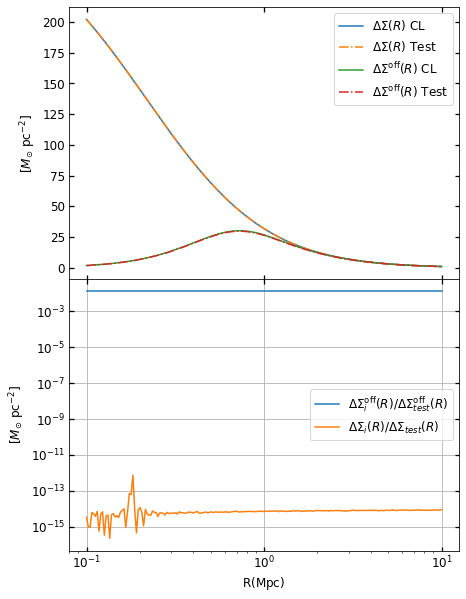

In [13]:
x1 = rbins.flatten()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace':0}, figsize=(7, 10))

axs[0].plot(x1, DeltaCluster.value, '-', label = '$\Delta\Sigma(R)$ CL')
axs[0].plot(x1, delta_sigma_NFW.flatten()*1.0E-12, '-.', label = '$\Delta\Sigma(R)$ Test')
axs[0].plot(x1, DeltaClusterOff.value, '-', label = '$\Delta\Sigma^\mathrm{off}(R)$ CL')
axs[0].plot(x1, dsigma.flatten()*1.0E-12, '-.', label = '$\Delta\Sigma^\mathrm{off}(R)$ Test')
axs[0].set_ylabel('$[M_{\odot}\ \mathrm{pc}^{-2}]$')
axs[0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[0].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3)
axs[0].legend(loc='best')

axs[1].set_xscale('log')
axs[1].set_xlabel('$\mathrm{R}(\mathrm{Mpc})$')

axs[1].plot(x1, np.abs(DeltaClusterOff.value/(dsigma.flatten()*1.0E-12) - 1.0), '-', label = '$\Delta\Sigma^\mathrm{off}_{i}(R)/\Delta\Sigma^\mathrm{off}_{test}(R)$')
axs[1].plot(x1, np.abs(DeltaCluster.value/(delta_sigma_NFW.flatten()*1.0E-12) - 1.0), '-', label = '$\Delta\Sigma_{i}(R)/\Delta\Sigma_{test}(R)$')
axs[1].set_yscale('log')
axs[1].set_ylabel('$[M_{\odot}\ \mathrm{pc}^{-2}]$')
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3)
axs[1].legend(loc='best')
axs[1].grid(True)
plt.savefig("deltaoff_third.pdf", dpi=300, bbox_inches= 'tight')

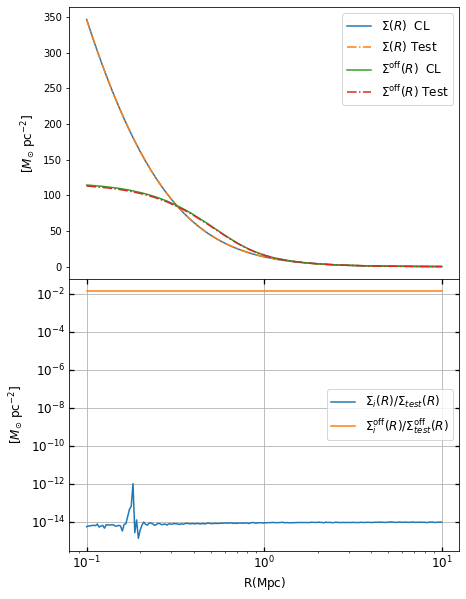

In [14]:
x1 = rbins.flatten()
fig, axs = plt.subplots (2, sharex=True, gridspec_kw={'hspace':0}, figsize=(7, 10))

axs[0].plot(x1, SigmaCluster.value, '-', label = '$\Sigma(R)$  CL')
axs[0].plot(x1, sigma.flatten()*1.0E-12, '-.', label = '$\Sigma(R)$ Test')
axs[0].plot(x1, SigmaClusterOff.value, '-', label = '$\Sigma^\mathrm{off}(R)$  CL')
axs[0].plot(x1, sigma_NFW_off.flatten()*1.0E-12, '-.', label = '$\Sigma^\mathrm{off}(R)$ Test')
axs[0].set_ylabel('$[M_{\odot}\ \mathrm{pc}^{-2}]$')
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3)
axs[0].legend(loc='best')

axs[1].set_xscale('log')
axs[1].set_xlabel('$\mathrm{R}(\mathrm{Mpc})$')
axs[1].plot(x1, np.abs(SigmaCluster.value/(sigma.flatten()*1.0E-12) - 1.0), '-', label = '$\Sigma_{i}(R)/\Sigma_{test}(R)$')
axs[1].plot(x1, np.abs(SigmaClusterOff.value/(sigma_NFW_off.flatten()*1.0E-12) - 1.0), '-', label = '$\Sigma^\mathrm{off}_{i}(R)/\Sigma^\mathrm{off}_{test}(R)$')
axs[1].set_yscale('log')
axs[1].set_ylabel('$[M_{\odot}\ \mathrm{pc}^{-2}]$')
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3, labelsize= 12)
axs[1].tick_params(which='major', direction='in', right=True, top=True, length=4.5, width=1.3)
axs[1].legend(loc='best')
axs[1].grid(True)
plt.savefig("sigmaoff_third.pdf", dpi=300, bbox_inches= 'tight')